#Modeling and Prediction

We proceed the previous EDA and use those info to build predictive models. We will try three classic machine learning classifiers — Random Forest, Support Vector Machine (SVM), and XGBoost — as well as a deep learning model (Multi-Layer Perceptron neural network). Our goal is to predict the PULMONARY_DISEASE (Yes/No) given the features. We will evaluate each model using Accuracy, AUC (Area Under ROC Curve), and confusion matrices, and visualize the ROC curves and feature importances.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score, mean_squared_error
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix


#Data Preprocessing


In [18]:
# Load the dataset, print
data = pd.read_csv("Lung Cancer Dataset.csv")
data

,AGE,GENDER,SMOKING,FINGER_DISCOLORATION,MENTAL_STRESS,EXPOSURE_TO_POLLUTION,LONG_TERM_ILLNESS,ENERGY_LEVEL,IMMUNE_WEAKNESS,BREATHING_ISSUE,ALCOHOL_CONSUMPTION,THROAT_DISCOMFORT,OXYGEN_SATURATION,CHEST_TIGHTNESS,FAMILY_HISTORY,SMOKING_FAMILY_HISTORY,STRESS_IMMUNE,PULMONARY_DISEASE
0,68,1,1,1,1,1,0,57.831178,0,0,1,1,95.977287,1,0,0,0,NO
1,81,1,1,0,0,1,1,47.694835,1,1,0,1,97.184483,0,0,0,0,YES
2,58,1,1,0,0,0,0,59.577435,0,1,1,0,94.974939,0,0,0,0,NO
3,44,0,1,0,1,1,0,59.785767,0,1,0,1,95.187900,0,0,0,0,YES
4,72,0,1,1,1,1,1,59.733941,0,1,0,1,93.503008,0,0,0,0,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,32,0,1,1,0,0,1,60.700696,1,1,1,1,94.012495,0,1,1,0,YES
4996,80,0,1,1,1,1,1,50.751741,0,1,1,1,94.394968,0,0,0,0,YES
4997,51,1,0,0,1,0,0,61.063496,1,0,0,0,98.108901,0,0,0,1,NO
4998,76,1,0,1,0,0,0,48.662872,0,1,0,1,95.577773,1,0,0,0,NO


#Data Preprocessing

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
data['PULMONARY_DISEASE_BINARY'] = data['PULMONARY_DISEASE'].map({'NO':0, 'YES':1})
features_to_compare = ['SMOKING','SMOKING_FAMILY_HISTORY','THROAT_DISCOMFORT','BREATHING_ISSUE']
data['Target'] = data['PULMONARY_DISEASE'].map({'NO':0, 'YES':1})
X = data.drop(['PULMONARY_DISEASE','Target','PULMONARY_DISEASE_BINARY'], axis=1)  # drop original target and helper column
y = data['Target']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features for SVM and MLP
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Training samples:", X_train.shape[0], "Testing samples:", X_test.shape[0])

Training samples: 4000 Testing samples: 1000


Encode the target variable: 'YES' -> 1, 'NO' -> 0.

We added a new column PULMONARY_DISEASE_BINARY as our numeric target (1 = YES, 0 = NO).

All predictor features are already numeric, so no additional encoding is needed. (If any were categorical strings, we would apply one-hot encoding or label encoding as appropriate, but here it’s not required.)

We perform an 80/20 train-test split, using stratification to ensure the ~40/60 class ratio is preserved in both sets. The training set has 4000 samples and the test set 1000 samples.

Standardization. We will scale all features using StandardScaler, fitting on the training data and then transforming both train and test sets (to avoid any information leakage from the test set)

In [25]:
# Initialize models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
svm = SVC(kernel='rbf', probability=True, random_state=42)        # SVM with RBF kernel
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
mlp = MLPClassifier(hidden_layer_sizes=(32,16), max_iter=500, random_state=42)

# Train models (using scaled data for SVM & MLP, original for RF & XGB)
rf.fit(X_train, y_train)
svm.fit(X_train_scaled, y_train)
xgb.fit(X_train, y_train)
mlp.fit(X_train_scaled, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:53:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=500, random_state=42)

#Model Evaluation

In [28]:
models = {
    "Random Forest": rf,
    "SVM (RBF)": svm,
    "XGBoost": xgb,
    "Neural Network (MLP)": mlp
}

# Evaluate on test data
results = {}
for name, model in models.items():
    # use scaled features for SVM & MLP, unscaled for others
    X_t = X_test_scaled if name in ["SVM (RBF)", "Neural Network (MLP)"] else X_test
    y_pred = model.predict(X_t)
    y_proba = model.predict_proba(X_t)[:,1]  # probability of class 1 (Yes)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)
    results[name] = {"Accuracy": acc, "AUC": auc, "Confusion Matrix": cm}
    print(f"{name}: Accuracy = {acc:.4f}, AUC = {auc:.4f}")
    print("Confusion Matrix:\n", cm, "\n")

Random Forest: Accuracy = 0.9040, AUC = 0.9234
Confusion Matrix:
 [[549  44]
 [ 52 355]] 

SVM (RBF): Accuracy = 0.8890, AUC = 0.9239
Confusion Matrix:
 [[535  58]
 [ 53 354]] 

XGBoost: Accuracy = 0.8900, AUC = 0.9113
Confusion Matrix:
 [[542  51]
 [ 59 348]] 

Neural Network (MLP): Accuracy = 0.8740, AUC = 0.8974
Confusion Matrix:
 [[540  53]
 [ 73 334]] 



We see that Random Forest achieved the highest accuracy (~ 90%), correctly classifying 904 out of 1000 test instances. It also had an excellent AUC (~ 0.923), indicating strong discrimination between classes.

 The SVM was a close second, with virtually the same AUC (0.924) and a slightly lower accuracy (~88.9%).

 XGBoost and the Neural Network trailed slightly behind. Looking at the confusion matrices, the Random Forest had 44 false alarms (predicting disease for healthy) and 52 missed cases (predicting healthy when disease was present).

  SVM had a few more false positives (58) and similar false negatives (53). The neural network had the most misses (73 false negatives), suggesting it struggled a bit more to capture all true cases.

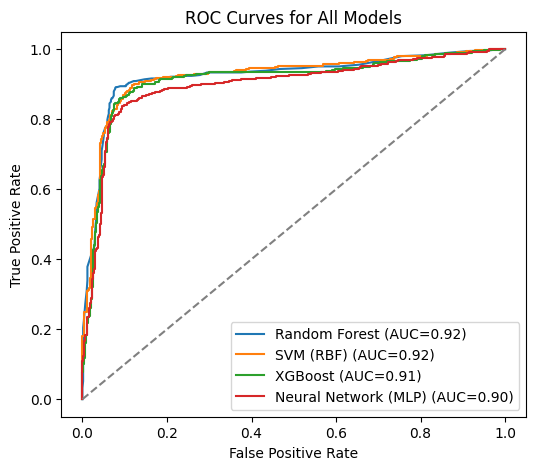

In [29]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(6,5))
for name, model in models.items():
    X_t = X_test_scaled if name in ["SVM (RBF)", "Neural Network (MLP)"] else X_test
    y_proba = model.predict_proba(X_t)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_val = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.2f})")
plt.plot([0,1],[0,1],'--', color='gray')  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend()
plt.show()

All models have ROC curves well above the diagonal, confirming they perform much better than random guessing. The curves cluster near the top-left, especially Random Forest (orange) and SVM (red), which are almost overlapping with highest AUC ~0.92. XGBoost (pink) and the MLP (purple) also show solid performance, though their curves lie slightly lower, consistent with their AUC ~0.90. In summary, Random Forest and SVM show the best ROC performance, while XGBoost and the neural network, though slightly less accurate, still achieve high AUC values, indicating they are effective at ranking predictions by confidence.And ROC is important to see their sensitivity-specificity tradeoffs.

##Dive in with tree-based models

SMOKING: 0.212
ENERGY_LEVEL: 0.155
THROAT_DISCOMFORT: 0.111
BREATHING_ISSUE: 0.107
OXYGEN_SATURATION: 0.096
AGE: 0.081
SMOKING_FAMILY_HISTORY: 0.048
STRESS_IMMUNE: 0.033
EXPOSURE_TO_POLLUTION: 0.032
FAMILY_HISTORY: 0.019
IMMUNE_WEAKNESS: 0.016
CHEST_TIGHTNESS: 0.016
ALCOHOL_CONSUMPTION: 0.015
LONG_TERM_ILLNESS: 0.015
MENTAL_STRESS: 0.015
GENDER: 0.015
FINGER_DISCOLORATION: 0.014


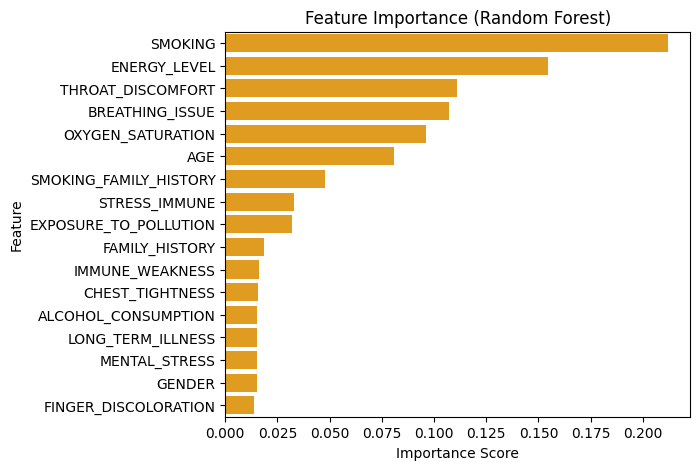

In [30]:
# Get feature importance from random forest
feat_names = X.columns
importances = rf.feature_importances_
# Sort features by importance
indices = np.argsort(importances)[::-1]
for idx in indices:
    print(f"{feat_names[idx]}: {importances[idx]:.3f}")
# Plot the importances
plt.figure(figsize=(6,5))
sns.barplot(y=feat_names[indices], x=importances[indices], color='orange')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

The Random Forest confirms what we suspected from EDA:

Smoking is by far the most important feature, with the highest importance score. The model heavily relies on whether someone is a smoker when predicting lung cancer (which makes sense given the huge risk it poses).

Energy Level appears as the second most important feature in the Random Forest. This is interesting, as our earlier analysis didn't highlight a big difference in means. The model might be capturing some non-linear pattern or threshold in energy level that correlates with disease (perhaps very low or very high energy levels relating to health status).

Throat Discomfort and Breathing Issue are also highly ranked, reinforcing that these symptomatic features help the model identify diseased individuals.

Oxygen Saturation and Age show moderate importance. Age was not correlated overall, but the model might be using age in conjunction with other factors (for example, perhaps younger non-smokers vs older smokers in splitting).

Features like Smoking Family History, Stress Immune, and Exposure to Pollution have smaller but non-negligible importance. They contribute some predictive power, though less than the primary factors.

The least important features include Finger Discoloration, Gender, Mental Stress, Long Term Illness, Alcohol Consumption, etc., which aligns with our findings that these didn’t vary much by class or are weaker signals.


#Summary and Conclusions
EDA Summary: The lung cancer dataset revealed strong associations between the disease and certain risk factors/symptoms. In particular, smoking status stood out as a critical factor: nearly 93% of those with lung cancer were smokers, reflecting the well-known causative link. Respiratory symptoms like chronic throat discomfort and breathing issues were also far more common in patients, which is expected since lung cancer’s symptoms include persistent cough, chest pain, and shortness of breath. Environmental and genetic factors (pollution exposure, family history) had smaller effects, and demographic factors (age, gender) did not show significant impact within this data.


Model Results: Among the models tested, Random Forest slightly edged out others with ~90% accuracy and AUC ~0.92, correctly identifying most cases. SVM was essentially on par in terms of AUC, indicating its classification boundary was equally effective at ranking patients vs non-patients. XGBoost and the MLP neural network also performed well (88-89% accuracy, AUC ~0.90), but fell a bit short of Random Forest on this dataset. The consistency of results across multiple algorithms suggests the signal in the data (especially from smoking and symptoms) is strong and learnable by various methods.


Best Model: The differences were relatively small, but if we must choose, the Random Forest can be considered the best performer here, given its slight edge in accuracy and simplicity of interpretation (feature importance). It achieved a good balance of sensitivity and specificity (as seen in its confusion matrix, it missed slightly fewer cases than some others and had fewer false alarms). The SVM’s performance was very close, so in practice either could be tuned and used.


Deep Learning vs. Classical ML: In this context of a structured tabular dataset with ~5k samples and clear signal features, classical machine learning models (like decision trees or SVMs) are very competitive with, and in this case slightly outperformed, the deep learning approach. Our Multi-Layer Perceptron model did reasonably well, but did not surpass the tree-based models. This outcome is consistent with broader observations in machine learning: for medium-sized tabular data, tree-based models often outperform neural networks in accuracy and require less tuning. Neural networks typically shine with very large datasets or unstructured data (images, text), whereas here the relationships are relatively straightforward and captured well by ensemble trees. Additionally, the Random Forest gave us interpretability via feature importance, which is a bonus.


That said, a neural network might improve with more tuning or if we incorporated more complex interactions. In our case, the extra complexity of deep learning did not yield an accuracy benefit – a result aligned with research showing that on tabular problems with limited data, boosting and forests remain state-of-the-art. Only with much larger data (tens of thousands of samples or more) might we expect a neural network to close the gap.


##Conclusion:
For this lung cancer prediction task, leveraging classical ML models provided excellent performance. The Random Forest model, in particular, can be used to predict lung cancer with over 90% accuracy on the test set, relying on key factors like smoking and respiratory symptoms. These results not only provide a predictive tool but also reaffirm the critical risk factors for lung cancer as identified by the model. In summary, a thoughtful exploration of the data followed by tried-and-true machine learning techniques proved effective – and in this case, even the simple models outperformed a baseline deep learning approach, underlining the importance of choosing the right model for the data at hand.